In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('C:/Users/Agusti Frananda/Data Mining Kelompok/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

# Treat Missing Data

In [5]:
# check for missing values
missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'percent_missing': (df.isnull().sum()/20000)*100})
missing_data

,total_missing,percent_missing
InvoiceNo,0,0.00
StockCode,0,0.00
Description,1454,7.27
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00
CustomerID,135080,675.40
Country,0,0.00


In [6]:
# remove missing values
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# Exploratory Data Analysis

In [8]:
df.rename(columns = {'InvoiceNo':'INVOICE NUMBER'}, inplace = True)
df.rename(columns = {'StockCode':'STOCK CODE'}, inplace = True)
df.rename(columns = {'Description':'DESCRIPTION'}, inplace = True)
df.rename(columns = {'Quantity':'QUANTITY'}, inplace = True)
df.rename(columns = {'InvoiceDate':'INVOICE DATE'}, inplace = True)
df.rename(columns = {'UnitPrice':'UNIT PRICE'}, inplace = True)
df.rename(columns = {'CustomerID':'CUSTOMER ID'}, inplace = True)
df.rename(columns = {'Country':'COUNTRY'}, inplace = True)

In [9]:
df.columns

Index(['INVOICE NUMBER', 'STOCK CODE', 'DESCRIPTION', 'QUANTITY',
       'INVOICE DATE', 'UNIT PRICE', 'CUSTOMER ID', 'COUNTRY'],
      dtype='object')

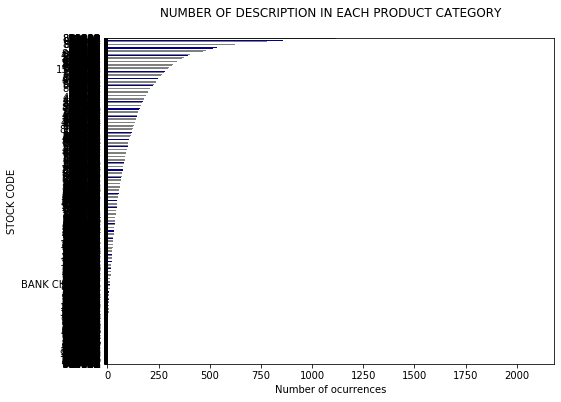

In [10]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df.groupby('STOCK CODE').DESCRIPTION.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF DESCRIPTION IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

# Data Preparation

# StockCode to string datatype

In [11]:
df['STOCK CODE']= df['STOCK CODE'].astype(str)

# Check out the number of unique customers

In [12]:
customers = df["CUSTOMER ID"].unique().tolist()
len(customers)

4372

# The data of 90% of the customers to create word2vec embeddings

In [13]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CUSTOMER ID'].isin(customers_train)]
validation_df = df[~df['CUSTOMER ID'].isin(customers_train)]

# Sequences of purchases made by the customers in the dataset for both the train and validation set

In [14]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CUSTOMER ID"] == i]["STOCK CODE"].tolist()
    purchases_train.append(temp)

100%|█████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:06<00:00, 580.57it/s]


In [15]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CUSTOMER ID'].unique()):
    temp = validation_df[validation_df["CUSTOMER ID"] == i]["STOCK CODE"].tolist()
    purchases_val.append(temp)

100%|███████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 929.60it/s]


# Build word2vec Embeddings for Products

In [16]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3600827, 3638410)

In [17]:
model.init_sims(replace=True)

# Summary of model

In [18]:
print(model)

Word2Vec(vocab=3167, size=100, alpha=0.03)


# Extract the vectors of all the words in our vocabulary

In [19]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

C:\Users\Agusti Frananda\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(3167, 100)

# Visualize word2vec Embeddings

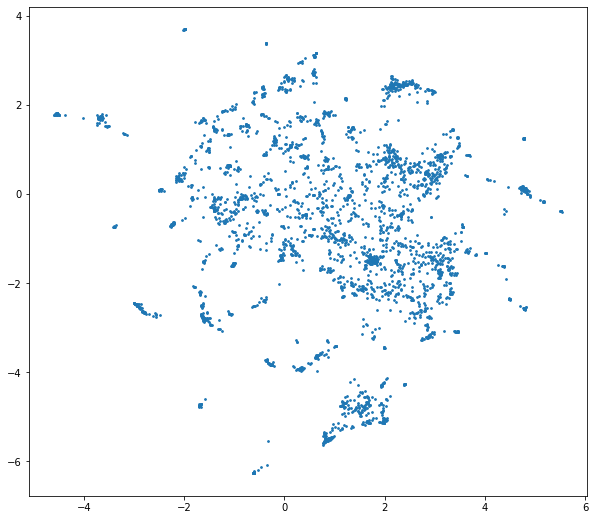

In [20]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

# Start Recommending Products

In [21]:
products = train_df[["STOCK CODE", "DESCRIPTION"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='STOCK CODE', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('STOCK CODE')['DESCRIPTION'].apply(list).to_dict()

C:\Users\Agusti Frananda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

# Top 6 similar products

In [23]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms    

In [24]:
similar_products(model['90019A'])

C:\Users\Agusti Frananda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
C:\Users\Agusti Frananda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('SILVER M.O.P ORBIT DROP EARRINGS', 0.7918110489845276),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7830843925476074),
 ('PINK BOUDICCA LARGE BRACELET', 0.7716693878173828),
 ('PINK HEART OF GLASS BRACELET', 0.7675923109054565),
 ('WHITE VINT ART DECO CRYSTAL NECKLAC', 0.759774923324585),
 ('RASPBERRY ANT COPPER FLOWER NECKLAC', 0.7573612928390503)]

# Similar products with average of all the vectors of product

In [25]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

# A separate list of purchase sequences for validation purposes

In [26]:
len(purchases_val[0])

109

# Function Aggregate Vectors

In [27]:
aggregate_vectors(purchases_val[0]).shape

C:\Users\Agusti Frananda\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(100,)

# The most similar products

In [28]:
similar_products(aggregate_vectors(purchases_val[0]))

C:\Users\Agusti Frananda\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\Agusti Frananda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('UTILTY CABINET WITH HOOKS', 0.7484524250030518),
 ('WOOD BLACK BOARD ANT WHITE FINISH', 0.746861457824707),
 ('LOVE BUILDING BLOCK WORD', 0.7309727668762207),
 ('CREAM HANGING HEART T-LIGHT HOLDER', 0.7269183993339539),
 ('CREAM SWEETHEART MINI CHEST', 0.7147558927536011),
 ('CREAM WALL PLANTER HEART SHAPED', 0.7126333117485046)]

# The last 10 products purchased

In [29]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

C:\Users\Agusti Frananda\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\Agusti Frananda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('WOODEN HEART CHRISTMAS SCANDINAVIAN', 0.729048490524292),
 ('WOODEN TREE CHRISTMAS SCANDINAVIAN', 0.7087500095367432),
 ('HOME BUILDING BLOCK WORD', 0.6739602088928223),
 ('LOVE BUILDING BLOCK WORD', 0.66248619556427),
 ('HEART WOODEN CHRISTMAS DECORATION', 0.6389244794845581),
 ('HOT WATER BOTTLE KEEP CALM', 0.6335406303405762)]